<a href="https://colab.research.google.com/github/ben-oxley/colab-opencl-experiments/blob/main/particle-sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!pip install pyopencl
!pip install pillow
from __future__ import division
import numpy as np
import pyopencl as cl
import pyopencl.array
from pyopencl.clrandom import rand as clrand
import pyopencl.cltypes as cltypes
from PIL import Image
from IPython.display import display

In [134]:
%load_ext pyopencl.ipython_ext

The pyopencl.ipython_ext extension is already loaded. To reload it, use:
  %reload_ext pyopencl.ipython_ext


In [135]:
print(pyopencl.get_platforms())
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

[<pyopencl.Platform 'NVIDIA CUDA' at 0x564e75df09e0>]


In [136]:
%%cl_kernel

__kernel void sum_vector(__global const float4 *a,
__global const float4 *b, __global float4 *c)
{
  int gid = get_global_id(0);
  c[gid].x = a[gid].x + b[gid].x;
 c[gid].y = a[gid].y + b[gid].y;
}

In [141]:
n = 10000000

a = cl.array.zeros(queue, n, dtype=cltypes.float4)
a = clrand(queue, (n,), dtype=cltypes.float4, a=0.0, b=1000.0)
print(a)


b_host = np.random.randn(n).astype(cltypes.float4)
b = cl.array.to_device(queue, b_host)
print(b)
c = cl.array.zeros(queue, n, dtype=cltypes.float4)

[(987.01953, 743.8042 , 358.38287 , 603.5935 )
 (334.96313, 607.47266, 802.75836 , 126.80499)
 (892.3844 , 645.0578 , 237.95021 , 804.9433 ) ...
 (544.1578 , 412.61908,  11.350016, 605.79175)
 (353.74496, 887.42224, 678.1937  , 773.01855)
 (291.04156, 949.88495, 264.10107 , 935.69086)]
[(-1.0958817 , -1.0958817 , -1.0958817 , -1.0958817 )
 ( 1.4662696 ,  1.4662696 ,  1.4662696 ,  1.4662696 )
 (-0.19975697, -0.19975697, -0.19975697, -0.19975697) ...
 (-0.11029562, -0.11029562, -0.11029562, -0.11029562)
 (-0.2646252 , -0.2646252 , -0.2646252 , -0.2646252 )
 ( 1.386777  ,  1.386777  ,  1.386777  ,  1.386777  )]


In [142]:
sum_vector(queue, (n,), None, a.data, b.data, c.data)

In [143]:
print(c.get())

[(985.92365, 742.7083 , 0., 0.) (336.4294 , 608.9389 , 0., 0.)
 (892.18463, 644.85803, 0., 0.) ... (544.0475 , 412.5088 , 0., 0.)
 (353.48035, 887.1576 , 0., 0.) (292.42834, 951.2717 , 0., 0.)]


[[13. 11.  9. ...  0.  2.  4.]
 [15. 15.  9. ...  0.  0.  1.]
 [12.  7.  8. ...  0.  0.  1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  0. ...  0.  0.  1.]]


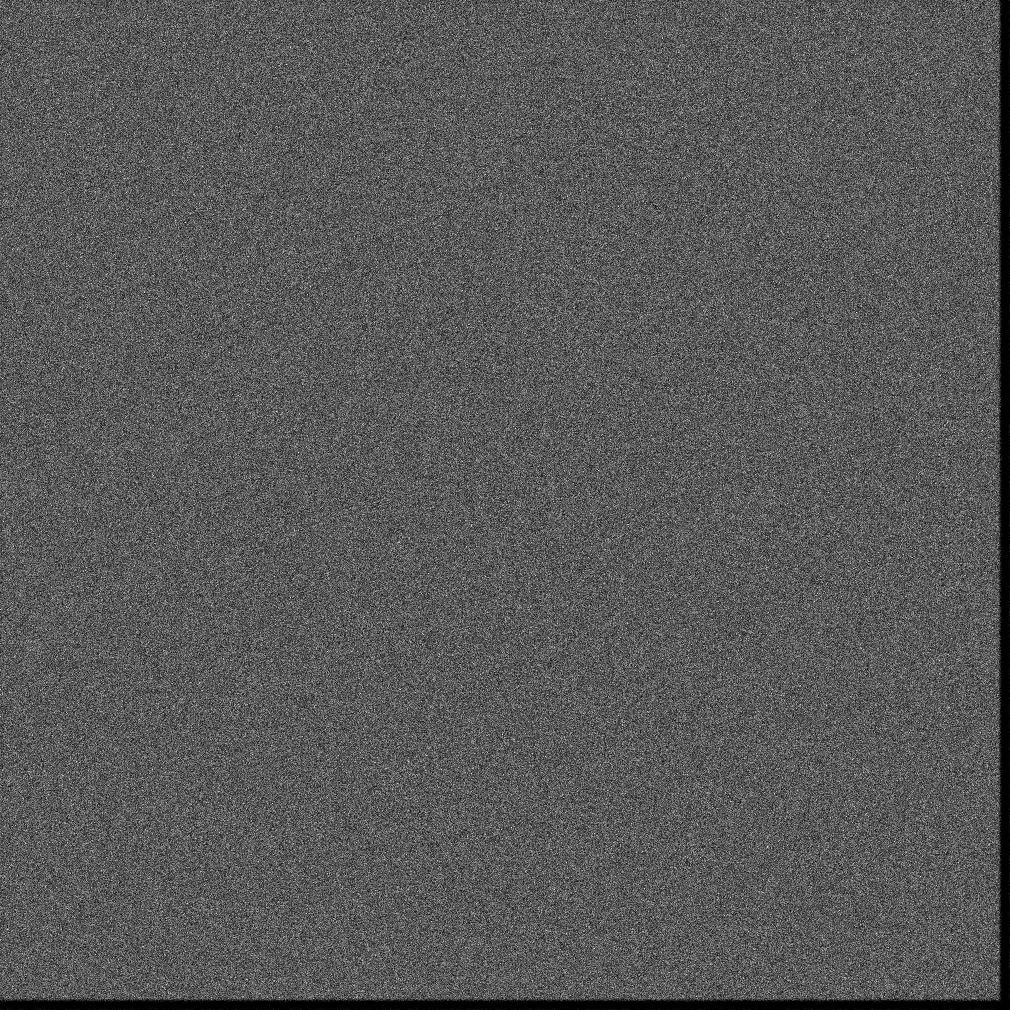

In [144]:
canvas = np.zeros((1010,1010))
for v in c.get():
  canvas[int(v[0])][int(v[1])] = canvas[int(v[0])][int(v[1])]  + 1
max = canvas.max()
img = Image.fromarray(np.uint8(canvas/max * (255)) , 'L')
img.show()
display(img)